In [8]:
import sys
print(sys.path)

['/Users/ekaterinapogodina/repo/GANS', '/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages', '/Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/IPython/extensions', '/Users/ekaterinapogodina/.ipython']


In [22]:
from pandas_datareader import data 
apple = data.DataReader('AFI.AX', 'yahoo', start='1/1/2010', end= '1/10/2015')
apple['Returns'] = apple['Adj Close'].pct_change()
mu = apple['Returns'].mean()
std = apple['Returns'].std()

def sample_data(n_samples=50000, seq_length=10):

    vectors = []

    for i in range(n_samples):
        daily_returns=np.random.normal(mu, std, seq_length)
        vectors.append(daily_returns)
    
    return np.asarray(vectors)

samples = sample_data()

In [30]:
x_train[0].shape

(784,)

In [31]:
samples.shape

(50000, 10)

In [68]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 16
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 16)           336         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_15[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            34          dense_15[0][0]                   
____________________________________________________________________________________________

In [69]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 404       
_________________________________________________________________
decoder (Model)              (None, 20)                388       
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [70]:
x_test = sample_data(10000, seq_length=20)

In [71]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.8581 - val_loss: 0.3879
Epoch 2/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.2358 - val_loss: 0.1823
Epoch 3/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.1728 - val_loss: 0.1654
Epoch 4/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.1637 - val_loss: 0.1607
Epoch 5/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.1607 - val_loss: 0.1588
Epoch 6/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.1594 - val_loss: 0.1579
Epoch 7/50
50000/50000 [==============================] - 1s 16us/step - loss: 0.1586 - val_loss: 0.1574
Epoch 8/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1582 - val_loss: 0.1571
Epoch 9/50
50000/50000 [==============================] - 1s 17us/step - loss: 0.1580 - val_loss: 0.1569
Epoch

In [72]:
from tqdm import tqdm

In [73]:
grid_x = np.linspace(-2, 2, 100)
grid_y = np.linspace(-2, 2, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:06, 15.37it/s]


In [74]:
ids = np.random.choice(10000, 100)

In [50]:
def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

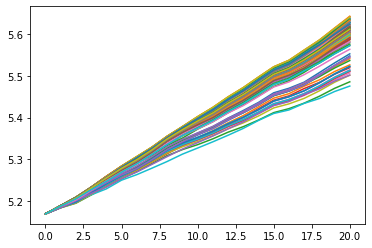

In [76]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [77]:
np.mean(gen_data), np.std(gen_data)

(0.003908278, 0.00067376724)

In [78]:
np.mean(samples), np.std(samples)

(0.003833227999222314, 0.0886252352820025)

In [79]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.2567840647288554


# More Layers

In [80]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 16
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
y = Dropout(0.6)(x)
y = Dense(intermediate_dim * 2, activation='relu')(y)
z_mean = Dense(latent_dim, name='z_mean')(y)
z_log_var = Dense(latent_dim, name='z_log_var')(y)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
y = Dropout(0.6)(x)
y = Dense(intermediate_dim * 2, activation='relu')(y)
outputs = Dense(original_dim, activation='sigmoid')(y)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

W0901 08:39:43.861546 4434335168 deprecation.py:506] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0901 08:39:43.864979 4434335168 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0901 08:39:44.017000 4434335168 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0901 08:39:44.107208 4434335168 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0901 08:39:44.155169 4434335168 nn_ops.p

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 16)           336         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16)           0           dense_18[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 32)           544         dropout_1[0][0]                  
____________________________________________________________________________________________

In [81]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1012      
_________________________________________________________________
decoder (Model)              (None, 20)                1252      
Total params: 2,264
Trainable params: 2,264
Non-trainable params: 0
_________________________________________________________________


In [82]:
x_test = sample_data(10000, seq_length=20)

In [84]:
vae.fit(x_train,
        epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 1s 22us/step - loss: 0.1742 - val_loss: 0.1578
Epoch 2/20
50000/50000 [==============================] - 1s 20us/step - loss: 0.1627 - val_loss: 0.1579
Epoch 3/20
50000/50000 [==============================] - 1s 20us/step - loss: 0.1599 - val_loss: 0.1579
Epoch 4/20
50000/50000 [==============================] - 1s 25us/step - loss: 0.1589 - val_loss: 0.1579
Epoch 5/20
50000/50000 [==============================] - 1s 24us/step - loss: 0.1583 - val_loss: 0.1579
Epoch 6/20
50000/50000 [==============================] - 1s 24us/step - loss: 0.1580 - val_loss: 0.1579
Epoch 7/20
50000/50000 [==============================] - 1s 24us/step - loss: 0.1579 - val_loss: 0.1579
Epoch 8/20
50000/50000 [==============================] - 1s 22us/step - loss: 0.1578 - val_loss: 0.1579
Epoch 9/20
50000/50000 [==============================] - 1s 20us/step - loss: 0.1577 - val_loss: 0.1579
Epoch

In [85]:
grid_x = np.linspace(-2, 2, 100)
grid_y = np.linspace(-2, 2, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:09, 15.09it/s]


In [86]:
ids = np.random.choice(10000, 100) 

def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

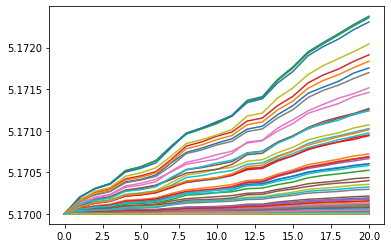

In [87]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [93]:
np.mean(gen_data),  np.std(gen_data)

(3.511489e-06, 6.433701e-06)

In [90]:
np.mean(x_train), np.std(x_train)

(0.0037623823574084196, 0.08867515769572544)

In [94]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.23986461294928
